## Loading the packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from random import randrange, uniform

## Set the current working directory

In [2]:
os.chdir("C:/Users/Arnav Phukan/Desktop/Projects/Cab Fare Prediction")

In [3]:
os.getcwd()

'C:\\Users\\Arnav Phukan\\Desktop\\Projects\\Cab Fare Prediction'

## Loading train data

In [4]:
train_data=(pd.read_csv('train_cab.csv',header=0)).drop(columns="pickup_datetime")

In [5]:
# Eliminating rows where pickup and drop locations are same¶
train_data=train_data[np.logical_and(train_data['pickup_longitude'] != train_data['dropoff_longitude'],
                                     train_data['pickup_latitude'] != train_data['dropoff_latitude'])]

In [6]:
# replace 0 with NA in the variables and convert the data wherever required for further operations
train_data['fare_amount']= train_data['fare_amount'].apply(pd.to_numeric, errors='coerce')
train_data['fare_amount']= train_data['fare_amount'].replace({0:np.nan})
train_data['passenger_count']=train_data['passenger_count'].fillna(0)
train_data['passenger_count']= train_data['passenger_count'].astype(int)
train_data['passenger_count']=train_data['passenger_count'].replace({0: np.nan})
train_data['pickup_longitude']= train_data['pickup_longitude'].replace({0:np.nan})
train_data['pickup_latitude']= train_data['pickup_latitude'].replace({0:np.nan})
train_data['dropoff_longitude']= train_data['dropoff_longitude'].replace({0:np.nan})
train_data['dropoff_latitude']= train_data['dropoff_latitude'].replace({0:np.nan})

In [7]:
train_data.shape

(15603, 6)

In [8]:
train_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0


## Missing Value Analysis

In [9]:
# calculate missing values
missing_val=pd.DataFrame(train_data.isnull().sum())

#Reset_index
missing_val=missing_val.reset_index()

#rename variable
missing_val=missing_val.rename(columns={'index': 'Variables',0: 'count'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['count']/len(train_data)*100)

#sort in descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
print(missing_val)


           Variables  count  Missing_percentage
0    passenger_count    112            0.717811
1        fare_amount     24            0.153817
2   pickup_longitude     12            0.076908
3    pickup_latitude     12            0.076908
4  dropoff_longitude     10            0.064090
5   dropoff_latitude      9            0.057681


## Missing Value Imputation

In [10]:
# imputation method
# Actual value=-73.9957
# Mean=-73.91159
# Median=-73.982
# KNN=-73.890529

In [11]:
#Create missing value, a small test to identify which method is good for imputation
train_data["pickup_longitude"].loc[70]

-73.99578100000001

In [12]:
train_data["pickup_longitude"].loc[70] = np.nan
train_data["pickup_longitude"].loc[70]

nan

In [13]:
#As it is found Mean is very close to original method we will proceed with imputation via mean
train_data['fare_amount'] = train_data['fare_amount'].fillna(train_data['fare_amount'].mean())
train_data['pickup_longitude']= train_data['pickup_longitude'].fillna(train_data['pickup_longitude'].mean())
train_data['pickup_latitude']= train_data['pickup_latitude'].fillna(train_data['pickup_latitude'].mean())
train_data['dropoff_longitude']= train_data['dropoff_longitude'].fillna(train_data['dropoff_longitude'].mean())
train_data['dropoff_latitude']= train_data['dropoff_latitude'].fillna(train_data['dropoff_latitude'].mean())


#And for category variables imputation is done with mode
train_data['passenger_count'] = train_data['passenger_count'].fillna(int(train_data['passenger_count'].mode()))

In [14]:

#Imputing the NAs in target variables may hamper the model, so it is preferred to remove NA rows of the data
train_data=train_data.dropna()

In [15]:
#conert into proper data type
convert_dic={'fare_amount' : 'float','passenger_count': 'int'}
train_data=train_data.astype(convert_dic)

In [16]:
train_data.shape

(15603, 6)

## Outlier Analysis

In [17]:
#save the data with in another place with different name

df = train_data.copy()
train_data = train_data.copy()

In [18]:
train_data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...
16062,6.5,-74.008820,40.718757,-73.998865,40.719987,1
16063,16.1,-73.981310,40.781695,-74.014392,40.715527,2
16064,8.5,-73.972507,40.753417,-73.979577,40.765495,1
16065,8.1,-73.957027,40.765945,-73.981983,40.779560,1


In [19]:
# irregular fare_amount are converted to NA 

train_data.loc[train_data['fare_amount']<0 , 'fare_amount']=np.nan
train_data.loc[train_data['fare_amount'] > 30, 'fare_amount']=np.nan
train_data=train_data.dropna()

In [20]:
train_data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...
16062,6.5,-74.008820,40.718757,-73.998865,40.719987,1
16063,16.1,-73.981310,40.781695,-74.014392,40.715527,2
16064,8.5,-73.972507,40.753417,-73.979577,40.765495,1
16065,8.1,-73.957027,40.765945,-73.981983,40.779560,1


In [21]:
pd.set_option('display.max_rows',16066)

In [22]:
#irregular passenger counts or those wgich are greater then 8 convertet to NaN
train_data.loc[train_data['passenger_count'] > 8,'passenger_count'] = np.nan

C:\Users\Arnav Phukan\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
#save numeric data names
coutliers = [ 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for list in coutliers:
    #Detect and replace with NA
    #Extract quartiles
    q75, q25 = np.percentile(train_data[list], [75 ,25])

    #Calculate IQR
    iqr = q75 - q25
   
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)

    # #Replace with NA
    train_data.loc[train_data[list] < minimum,list] = np.nan
    train_data.loc[train_data[list] > maximum,list] = np.nan

    # #Calculate missing value
    missing_val = pd.DataFrame(train_data.isnull().sum())

C:\Users\Arnav Phukan\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
#As Mean is the best method, we impute missing values/ in this case outlier values with mean

train_data['pickup_longitude'] = train_data['pickup_longitude'].fillna(train_data['pickup_longitude'].mean())
train_data['pickup_latitude'] = train_data['pickup_latitude'].fillna(train_data['pickup_latitude'].mean())
train_data['dropoff_longitude'] = train_data['dropoff_longitude'].fillna(train_data['dropoff_longitude'].mean())
train_data['dropoff_latitude'] = train_data['dropoff_latitude'].fillna(train_data['dropoff_latitude'].mean())

#imputed with mode for categorical variables
train_data['passenger_count'] = train_data['passenger_count'].fillna(int(train_data['passenger_count'].mode()))

C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [25]:
#convert the data type of categorical variable passenger count
train_data['passenger_count']=train_data['passenger_count'].astype('int')
train_data['passenger_count']=train_data['passenger_count'].astype('category')

C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Feature Selection

In [26]:
#haversine function

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [27]:
train_data['dist'] = \
    haversine( train_data['pickup_latitude'], train_data['pickup_longitude'],
                train_data['dropoff_latitude'], train_data['dropoff_longitude'])

C:\Users\Arnav Phukan\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
##Correlation analysis
#Correlation plot
numeric=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dist']
train_data_corr = train_data.loc[:,numeric]

                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000         -0.048822        -0.057861   
pickup_longitude     -0.048822          1.000000         0.667819   
pickup_latitude      -0.057861          0.667819         1.000000   
dropoff_longitude     0.047996          0.364438         0.293342   
dropoff_latitude     -0.077377          0.318268         0.442597   
dist                  0.670136         -0.045966        -0.081138   

                   dropoff_longitude  dropoff_latitude      dist  
fare_amount                 0.047996         -0.077377  0.670136  
pickup_longitude            0.364438          0.318268 -0.045966  
pickup_latitude             0.293342          0.442597 -0.081138  
dropoff_longitude           1.000000          0.595164  0.063158  
dropoff_latitude            0.595164          1.000000 -0.061745  
dist                        0.063158         -0.061745  1.000000  


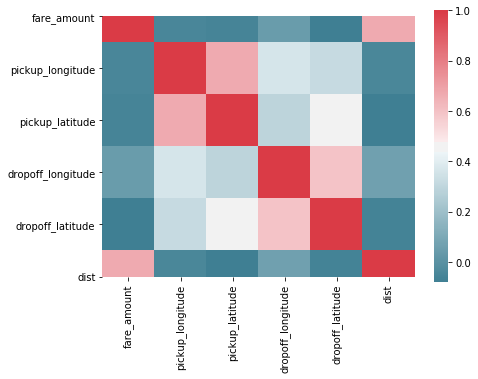

In [30]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = train_data_corr.corr()
print(corr)

#Plotted using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [31]:
#eliminate all data with the pickup and drop location points as same

train_data=train_data[np.logical_and(train_data['pickup_longitude'] != train_data['dropoff_longitude'],
                                     train_data['pickup_latitude'] != train_data['dropoff_latitude'])]

# Model Development

## Decision Tree

In [32]:
#Load libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [33]:
# Divide the data into train and test
train1, test1 = train_test_split(train_data, test_size=0.2)

In [34]:
# Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train1.iloc[:, 1:7], train1.iloc[:,0])

In [35]:
fit_DT

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [36]:
#Apply model on test data
predictions_DT = fit_DT.predict(test1.iloc[:,1:7])

In [37]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [38]:

MAPE(test1.iloc[:,0], predictions_DT)

28.490068771809185

In [39]:
#Error 28.774663291429192
#Accuracy 71.23

## Random Forest

In [40]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

In [41]:
RF_model = RandomForestRegressor(n_estimators = 10).fit(train1.iloc[:, 1:7], train1.iloc[:,0])

In [42]:
RF_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [43]:
RF_Predictions = RF_model.predict(test1.iloc[:, 1:7])

In [44]:
MAPE(test1.iloc[:,0], RF_Predictions)

25.141314500662997

In [45]:
#error 25.131668346501414
#accuracy 74.87

## KNN Imputation

In [46]:
#KNN implementation
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors = 1).fit(train1.iloc[: , 1:7], train1.iloc[:, 0])

In [56]:
#predict test cases
KNN_Predictions = KNN_model.predict(test1.iloc[: , 1:7])

In [48]:
MAPE(test1.iloc[:,0], KNN_Predictions)

34.13279431128859

In [49]:
#error is 34.21410560965663
#accuracy is 65.80

## Prediction on original test data

In [50]:
pred=(pd.read_csv('test.csv', header = 0 )).drop(columns="pickup_datetime")

In [51]:
#create Dist variable
pred['dist'] = \
    haversine( pred['pickup_latitude'], pred['pickup_longitude'],
                 pred['dropoff_latitude'], pred['dropoff_longitude'])

pred['fare_amount']=0
pred['passenger_count']=pred['passenger_count'].astype('category')

In [53]:
# Build model on the entire Train data
RF_model = RandomForestRegressor(n_estimators = 10).fit(train_data.iloc[:, 1:7], train_data.iloc[:,0])

#predict value
pred['fare_amount'] = RF_model.predict(pred.iloc[:, 0:6])

In [54]:
pred.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323259,9.34
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,8.48
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,5.02
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,9.74
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,15.71


In [55]:
#write output to csv
pred.to_csv("Predicted_Values.csv", index = False)